# Experimenty
**sobota 16.5.2020 23:59**
- odovzdat spravu + zdrojaky (jupyter) + data + podiel prace v jedn. fazach (zvlast dokument)


- vsetko z minula
- opis DM metod, dovod vyberu
- porovnat metody
- hyperparameter tuning
- metriky (acc-spravnost, prec-presnost, rec-uplnost,f1)


- metodologia - rozdelenie datasetu
- krizova validacia


- zhodnotenie co sa podarilo, porovnanie s ostatnymi (RelWork), dalsie smerovanie projektu
- literatura

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score

## Nacitanie opravenych dat

In [2]:
df_train = pd.read_csv('data/cars_train.csv').drop('Unnamed: 0', axis=1)
df_train.head(3)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Engine,Power,Seats,Price,Manufacturer,Price_km
0,Volkswagen Polo Diesel Trendline 1.2L,Jaipur,2011,77000,Diesel,Manual,First,1199.0,73.9,5.0,2.90,Volkswagen,1375.6231
1,Hyundai i10 Sportz,Hyderabad,2016,19947,Petrol,Manual,First,1197.0,78.9,5.0,4.50,Hyundai,1417.6668
2,Mahindra XUV500 W8 2WD,Kochi,2014,70963,Diesel,Manual,First,2179.0,140.0,7.0,7.83,Mahindra,941.1830


In [3]:
df_test = pd.read_csv('data/cars_test.csv').drop('Unnamed: 0', axis=1)
df_test.head(3)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Engine,Power,Seats,Price,Manufacturer,Price_km
0,Maruti Swift Dzire VDI,Hyderabad,2013,69000,Diesel,Manual,First,1248.0,74.0,5.0,5.75,Maruti,1458.522
1,Mahindra Scorpio 1.99 S4 Plus,Kochi,2017,26741,Diesel,Manual,First,1997.0,120.0,7.0,10.08,Mahindra,959.882
2,Mahindra XUV500 W8 2WD,Delhi,2014,86000,Diesel,Manual,First,2179.0,140.0,7.0,7.85,Mahindra,941.183


## Experimenty

### Rozdelenie datasetu
- df_train: 70%
- df_test: 30% - upravime na test: 15%, valid: 15%

In [4]:
def data_split(x_features, df_train, df_test):
    df_train = df_train.dropna()
    df_test = df_test.dropna()

    valid_limit = int(len(df_test)*0.5)

    x_train = df_train[x_features]
    x_test = df_test[x_features][:valid_limit]
    x_valid = df_test[x_features][valid_limit:]

    y_train = df_train['Price']
    y_test = df_test['Price'][:valid_limit]
    y_valid = df_test['Price'][valid_limit:]

    print(f"Data rozdelene: train = {len(x_train)}, test = {len(x_test)}, valid = {len(x_valid)}")
    return x_train, x_test, x_valid, y_train, y_test, y_valid

In [5]:
x_features = ['Year','Kilometers_Driven', 'Transmission', 'Owner_Type', 'Price_km',
              'Power', 'Seats', 'Engine', 'Manufacturer', 'Fuel_Type']

x_train, x_test, x_valid, y_train, y_test, y_valid = data_split(x_features, df_train, df_test)

Data rozdelene: train = 4140, test = 882, valid = 882


### One-hot encoding and scaling

In [6]:
def encoding(x_train, x_test, x_valid):
    
    x_train = pd.get_dummies(x_train)
    x_test = pd.get_dummies(x_test)
    x_valid = pd.get_dummies(x_valid)
    
    # filling missing columns in test_x and valid_x
    missing_test_cols = set(x_train.columns) - set(x_test.columns)
    missing_valid_cols = set(x_train.columns) - set(x_valid.columns)
    for col in missing_test_cols:
        x_test[col] = 0
    for col in missing_valid_cols:
        x_valid[col] = 0
        
    # delete x_test and x_valid columns not in x_train
    useless_test_cols =  set(x_test.columns) - set(x_train.columns)
    useless_valid_cols =  set(x_valid.columns) - set(x_train.columns)
    x_test.drop(useless_test_cols, axis=1, inplace=True)
    x_valid.drop(useless_valid_cols, axis=1, inplace=True)
    
    return x_train, x_test, x_valid

    
def scaling(x_train, x_test, x_valid):

    scaler = RobustScaler()
        
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    x_valid = scaler.transform(x_valid)
    
    return x_train, x_test, x_valid

In [7]:
x_train, x_test, x_valid = encoding(x_train, x_test, x_valid)
x_train, x_test, x_valid = scaling(x_train, x_test, x_valid)

## Trenovanie a evaluacia modelov

In [8]:
def evaluate(y_test, predict):
    print("RMSE: ", mean_squared_error(y_test, predict)) 
    if sum(predict<0) == 0:
        print("RMSLE: ", mean_squared_log_error(y_test, predict))
    else:
        print("RMSLE: ---")
    print("R2: ", r2_score(y_test, predict)) 
    print()

### LinearRegression

In [11]:
model = LinearRegression()
model.fit(x_train, y_train)
predict1 = model.predict(x_test)
        
evaluate(y_test, predict1)
print(model)
print()

RMSE:  41.298256580752245
RMSLE: ---
R2:  0.6786671262915784

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)



### DecisionTree

In [12]:
params = {
    'max_depth': stats.randint(1,15),
    'min_samples_leaf': stats.randint(1,5),
    'min_samples_split' : stats.randint(2,20)
}

random_optimization = RandomizedSearchCV(DecisionTreeRegressor(random_state=0), param_distributions=params, 
                                           random_state=23, n_jobs=-1, n_iter = 100)

random_optimization.fit(x_valid, y_valid)
model = random_optimization.best_estimator_

model.fit(x_train, y_train)
predict2 = model.predict(x_test)
      
evaluate(y_test, predict2)

print(model.get_params)
print()

print("Best features:")
concat = zip(model.feature_importances_, x_features)
for x, y in sorted(concat):
    if x > 0.02:
        print(x, y)


RMSE:  17.19089922761225
RMSLE:  0.061233988135791395
R2:  0.8662413015029045

<bound method BaseEstimator.get_params of DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=8,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=12,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')>

Best features:
0.027315410706142945 Power
0.04811501296039609 Kilometers_Driven
0.17875383967187072 Year
0.7391151857236324 Owner_Type


### RandomForest

In [13]:
params = {
    'max_depth': stats.randint(1,20),
    'min_samples_leaf': stats.randint(1,10),
    'min_samples_split' : stats.randint(1,20),
    'n_estimators' : [30,60,90,120,150,180,210,240],
    'bootstrap': [True, False]
}

random_optimization = RandomizedSearchCV(RandomForestRegressor(random_state=0), param_distributions=params, 
                                           random_state=23, n_jobs=-1, n_iter = 300)

random_optimization.fit(x_valid, y_valid)
model = random_optimization.best_estimator_

model.fit(x_train, y_train)
predict3 = model.predict(x_test)

evaluate(y_test, predict3)
print(model.get_params)
print()

print("Best features:")
concat = zip(model.feature_importances_, x_features)
for x, y in sorted(concat):
    if x > 0.02:
        print(x, y)


RMSE:  14.613974232388765
RMSLE:  0.04675609062108477
R2:  0.8862918019986603

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=16, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=90, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)>

Best features:
0.044930411523554994 Power
0.05631552918145926 Kilometers_Driven
0.17079641007521343 Year
0.7181838390554611 Owner_Type


### GradientBoostingRegressor

In [14]:
params = {
    'max_depth': stats.randint(1,10),
    'learning_rate': [0.1,0.125,0.15,0.175,0.2],
    'loss': ['ls', 'lad', 'huber', 'quantile'],
    'min_samples_leaf': stats.randint(1,5),
    'min_samples_split' : stats.randint(2,10),
    'n_estimators' : [30,60,90,120,150,180]
}

random_optimization = RandomizedSearchCV(GradientBoostingRegressor(random_state=0), param_distributions=params, 
                                           random_state=23, n_jobs=-1, n_iter = 300)

random_optimization.fit(x_valid, y_valid)
model = random_optimization.best_estimator_

model.fit(x_train, y_train)
predict4 = model.predict(x_test)

evaluate(y_test, predict4)
print(model.get_params)
print()

print("Best features:")
concat = zip(model.feature_importances_, x_features)
for x, y in sorted(concat):
    if x > 0.02:
        print(x, y)

RMSE:  18.009628757901144
RMSLE:  0.05019748148526217
R2:  0.8598709426902206

<bound method BaseEstimator.get_params of GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='lad', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=4, min_samples_split=7,
                          min_weight_fraction_leaf=0.0, n_estimators=90,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)>

Best features:
0.05381777941816107 Kilometers_Driven
0.11773270298852312 Power
0.24070991177276066 Year
0.5533182476749235 Owner_Type


### SVR

In [15]:
params = {
    'kernel': ('linear', 'rbf','poly'),
    'C': [1, 1.25, 1.5, 1.75, 2, 2.25, 2.5],
    'epsilon': [0.1, 0.15, 0.2, 0.25],
    'gamma': ['scale', 'auto'],
}

random_optimization = RandomizedSearchCV(SVR(), param_distributions=params, 
                                           random_state=23, n_jobs=-1, n_iter = 100)

random_optimization.fit(x_valid, y_valid)
model = random_optimization.best_estimator_

model.fit(x_train, y_train)
predict5 = model.predict(x_test)

evaluate(y_test, predict5)
print(model.get_params)
print()


RMSE:  21.459463517102495
RMSLE:  0.06990092159442632
R2:  0.8330285186080857

<bound method BaseEstimator.get_params of SVR(C=2.5, cache_size=200, coef0=0.0, degree=3, epsilon=0.15, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)>



### Zobrazenie grafov uspesnosti modelov

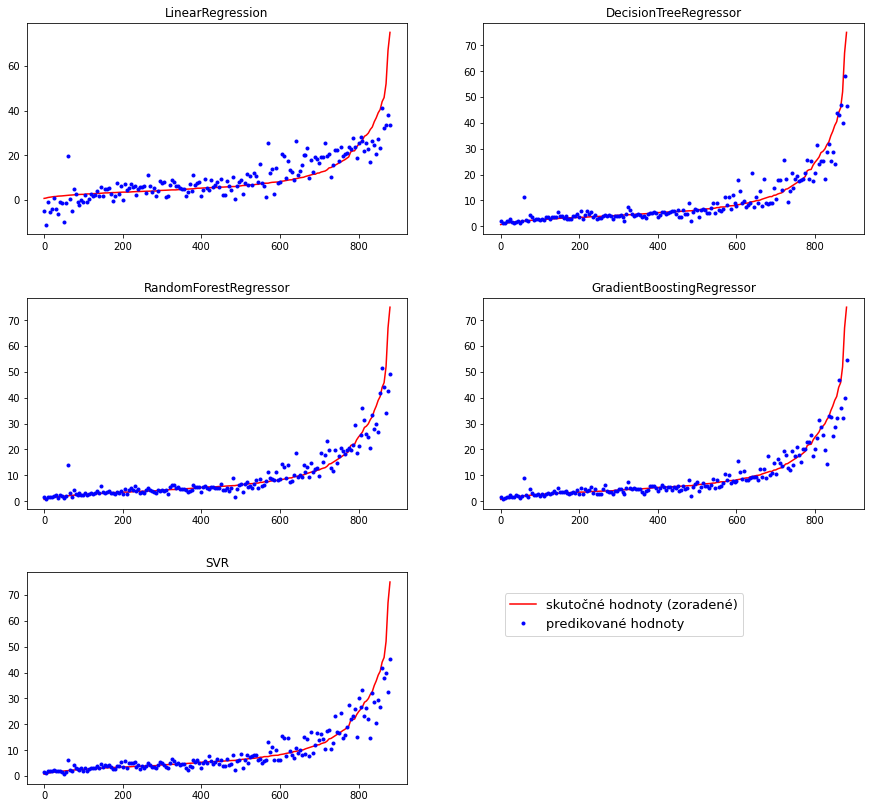

In [16]:
df1 = pd.DataFrame(predict1, y_test).sort_values(by='Price')
df2 = pd.DataFrame(predict2, y_test).sort_values(by='Price')
df3 = pd.DataFrame(predict3, y_test).sort_values(by='Price')
df4 = pd.DataFrame(predict4, y_test).sort_values(by='Price')
df5 = pd.DataFrame(predict5, y_test).sort_values(by='Price')
l = list(range(0, y_test.count()))

# Setting up the plot surface
fig = plt.figure(figsize=(15, 14))
gs = GridSpec(nrows=3, ncols=2, hspace= 0.3)
s = 5  # count_of_data / s - are showed

# First axes
ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(l[::s], df1.index[::s], c='red')
ax0.plot(l[::s], df1[0][::s], '.', c='blue')
ax0.set_title("LinearRegression")

# Second axes
ax1 = fig.add_subplot(gs[0, 1])
ax1.plot(l[::s], df2.index[::s], c='red')
ax1.plot(l[::s], df2[0][::s], '.', c='blue')
ax1.set_title("DecisionTreeRegressor")

# Third axes
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(l[::s], df3.index[::s], c='red')
ax2.plot(l[::s], df3[0][::s], '.', c='blue')
ax2.set_title("RandomForestRegressor")

# 4. axes
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(l[::s], df4.index[::s], c='red')
ax3.plot(l[::s], df4[0][::s], '.', c='blue')
ax3.set_title("GradientBoostingRegressor")

# 5. axes
ax4 = fig.add_subplot(gs[2, 0])
ax4.plot(l[::s], df5.index[::s], c='red',  label='skutočné hodnoty (zoradené)')
ax4.plot(l[::s], df5[0][::s], '.', c='blue', label='predikované hodnoty')
ax4.set_title("SVR")
plt.gca().legend(loc='center right', bbox_to_anchor=(1.9, 0.8), prop={'size': 13})


# fig.savefig('gridspec.png') # save whole cell with graphs as image

---

## 2. iteracia
- vyber 5 najlepsich crt

In [9]:
x_features = ['Year','Kilometers_Driven', 'Owner_Type', 'Power', 'Price_km', 'Transmission']

x_train, x_test, x_valid, y_train, y_test, y_valid = data_split(x_features, df_train, df_test)

Data rozdelene: train = 4140, test = 882, valid = 882


In [10]:
x_train, x_test, x_valid = encoding(x_train, x_test, x_valid)
x_train, x_test, x_valid = scaling(x_train, x_test, x_valid)

### Teraz spustime trenovanie a evaluaciu modelov znovu (aby sme nemali duplikatny kod)